# Multivariate Regression
Migration Direction ~ Environmental varibales

Yangkang Chen

Aug 18, 2023

In [1]:
import sys
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=6

import pickle
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import pymc.sampling.jax as pmjax
import jax
# import tensorflow_probability.substrates.jax as tfp
# jax.scipy.special.erfcx = tfp.math.erfcx
# from fastprogress.fastprogress import master_bar, progress_bar
# from fastprogress.fastprogress import force_console_behavior
# master_bar, progress_bar = force_console_behavior()
import pytensor.tensor as pt
import geopandas as gpd
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
### load data
data = pd.read_csv('./alldt.csv')
sp_list = list(data.sp.unique())

# EDA Test (Please skip this)

In [3]:
#### autumn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

x_names = ['Wind','prec','tprt','ele','evi']
data_autumn = data[data.sa=='Autumn']
# imputer = SimpleImputer(strategy='mean')
imputer = IterativeImputer(random_state=42, estimator=RandomForestRegressor(random_state=42))
data_autumn = data_autumn[x_names + ['dir_aut','sp']]
data_autumn = data_autumn.dropna(subset='dir_aut')

### indexing name
sp_index = pd.factorize(data_autumn['sp'])[0]
sp_name = data_autumn['sp']
del data_autumn['sp']

###
data_autumn[data_autumn.columns] = imputer.fit_transform(data_autumn)

y = data_autumn['dir_aut']
x = data_autumn[x_names]
x_stded = x.copy()
x_stded[x_stded.columns] = StandardScaler().fit_transform(x_stded)



In [4]:
### check RandomForest feature importance
m = RandomForestRegressor(random_state=42).fit(x, y)
dict(zip(m.feature_names_in_, m.feature_importances_))


{'Wind': 0.19964575302844353,
 'prec': 0.22557466893679787,
 'tprt': 0.36747258364322305,
 'ele': 0.11093557408233745,
 'evi': 0.09637142030919799}

In [5]:
data[x_names].corr()

,Wind,prec,tprt,ele,evi
Wind,1.000000,-0.058516,-0.005419,0.125995,-0.069015
prec,-0.058516,1.000000,0.359937,-0.096161,-0.034010
tprt,-0.005419,0.359937,1.000000,-0.424012,-0.068558
ele,0.125995,-0.096161,-0.424012,1.000000,0.069777
evi,-0.069015,-0.034010,-0.068558,0.069777,1.000000


**Results show that the is no strong correlation along these 5 variables**



# Start modeling

In [6]:
def BS_regression_sp_as_random_effect(x_stded, y, sp_index, TUNES=3000):
    '''
    Build a multivariate regression model using species as random effect (hierarchical modeling)
    '''
    with pm.Model() as model:
        sp_index = sp_index
        model.add_coord('sp_index', sp_index)
        
        x_stded_obs = x_stded.values
        y_obs = y.values
        
        ### params
        mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=100)
        mu_beta = pm.Normal('mu_beta', mu=np.zeros(x_stded_obs.shape[1]), 
                        sigma=np.ones(x_stded_obs.shape[1]))
        
        ###
        sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=10)
        alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha, shape=(len(np.unique(sp_index)),1))
        sigma_beta = pm.HalfNormal('sigma_beta', sigma=1)
        beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=(len(np.unique(sp_index)),x_stded_obs.shape[1]))
        
        ###
        mu_y = pm.Deterministic('mu_y', alpha[sp_index, 0] + pm.math.sum(x_stded_obs * beta[sp_index, :], axis=1))
        sigma_y = pm.HalfNormal('sigma_y', sigma=1)
        y_modeled = pm.Normal('y_modeled', mu=mu_y, sigma=sigma_y, observed=y_obs)
        
    SAMPLE_SIZE=3000
    SAMPLE_CHAINS=4
    SAMPLE_CORES=4
    # TUNES=2500
    with model:
        idata = pmjax.sample_numpyro_nuts(SAMPLE_SIZE,chains=SAMPLE_CHAINS,cores=SAMPLE_CORES, tune=TUNES, progressbar=True)

    return idata


In [7]:
def BS_regression_sp_overall(x_stded, y, TUNES=3000):
    '''
    Build a multivariate regression model using pooled species
    '''
    with pm.Model() as model:
        
        x_stded_obs = x_stded.values
        y_obs = y.values
        
        ### params
        mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=100)
        mu_beta = pm.Normal('mu_beta', mu=np.zeros(x_stded_obs.shape[1]), 
                        sigma=np.ones(x_stded_obs.shape[1]))
        
        ###
        mu_y = pm.Deterministic('mu_y', mu_alpha + x_stded_obs @ mu_beta)
        sigma_y = pm.HalfNormal('sigma_y', sigma=1)
        y_modeled = pm.Normal('y_modeled', mu=mu_y, sigma=sigma_y, observed=y_obs)
        
    SAMPLE_SIZE=3000
    SAMPLE_CHAINS=4
    SAMPLE_CORES=4
    # TUNES=2500
    with model:
        idata = pmjax.sample_numpyro_nuts(SAMPLE_SIZE,chains=SAMPLE_CHAINS,cores=SAMPLE_CORES, tune=TUNES, progressbar=True)

    return idata


In [8]:
def check_convergence(idata, vars):
    rhat_ = az.rhat(idata)
    ess_ = az.ess(idata)
    
    pass_1 = True if float(rhat_['mu_beta'].max())<1.03 else False
    pass_2 = True if float(ess_['mu_beta'].min())>400 else False
        
    if pass_1 & pass_2:
        return True
    else:
        return False
     
        

In [9]:
def forest_plot(idata, var_list):
    '''
    Plot the regression coefficients
    '''

    plt.figure(figsize=(6,6))
    betas = np.concatenate(idata.posterior['mu_beta'].values, axis=0)
    plot_df = pd.DataFrame({
        'var':var_list,
        'ind':list(range(len(var_list))),
        'mean_eff': [betas[:,i].mean() for i in range(len(var_list))],
        'std_eff': [betas[:,i].std() for i in range(len(var_list))],
        'P(coef!=0)': [np.min([np.sum(betas[:,i]>0)/len(betas[:,i]), np.sum(betas[:,i]<0)/len(betas[:,i])]) for i in range(len(var_list))]
    })
    
    var_replace_list = {
        'Wind': 'Wind cost', 
        'prec': 'Precipitation', 
        'tprt': 'Temperature', 
        'ele': 'Elevation', 
        'evi': 'Vegetation'
    }
    for k in var_replace_list.keys():
        plot_df['var'] = plot_df['var'].replace(k, var_replace_list[k])
    
    plot_df = plot_df.sort_values(by='var').reset_index(drop=True)

    for index,i in plot_df.iterrows():
        plt.plot(
            [i.mean_eff - 1.96*i.std_eff, i.mean_eff  + 1.96*i.std_eff],
            [index, index]
        )
        plt.scatter(
            [i.mean_eff],[index]
        )
    plt.plot([0,0], [0-1, index+1], linestyle='dashed', color='grey')
    plt.yticks(list(range(len(var_list))), list(plot_df['var']), fontsize=18)
    plt.xticks(fontsize=15)
    plt.title('Environmental features explain migration direction', fontsize=20)
    plt.tight_layout()
    
    return plot_df
    # plt.savefig('./Traits_forest_plot_on_PMP.pdf')
    


Compiling...
Compilation time =  0:00:00.450152
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:01.773412
Transforming variables...
Transformation time =  0:00:00.038921


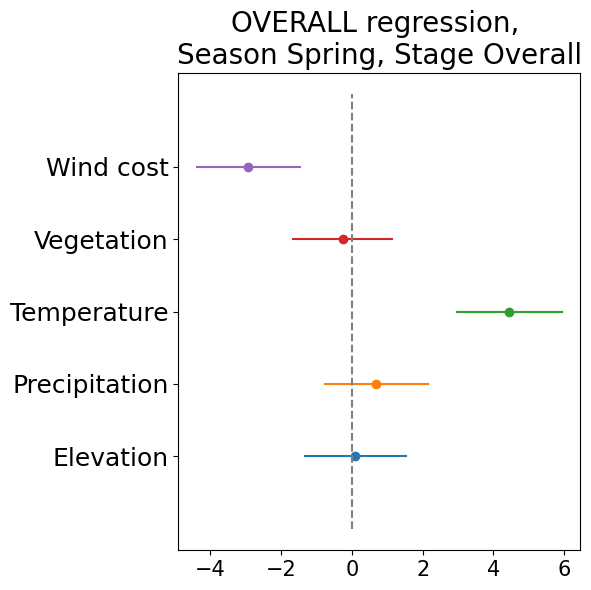

Compiling...
Compilation time =  0:00:00.862231
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:03.561216
Transforming variables...
Transformation time =  0:00:00.089697


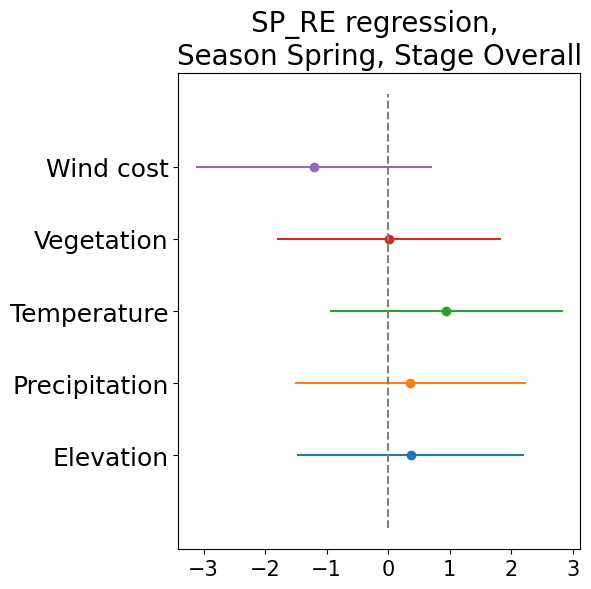

Compiling...
Compilation time =  0:00:00.431839
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:01.752171
Transforming variables...
Transformation time =  0:00:00.013971


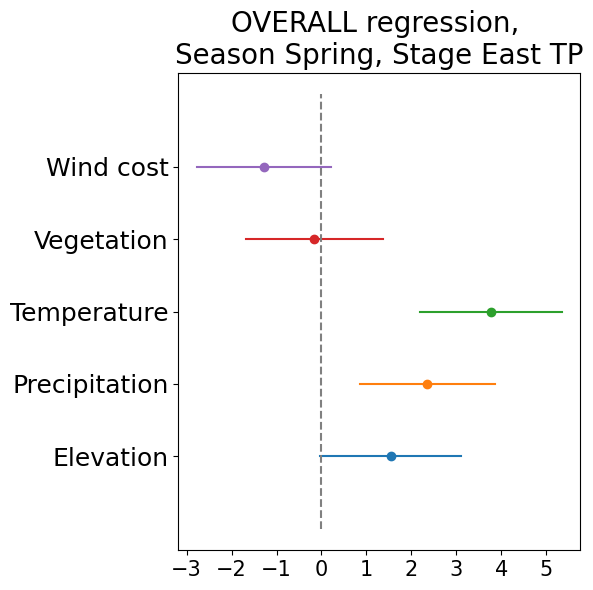

Compiling...
Compilation time =  0:00:00.846492
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:03.098183
Transforming variables...
Transformation time =  0:00:00.049664


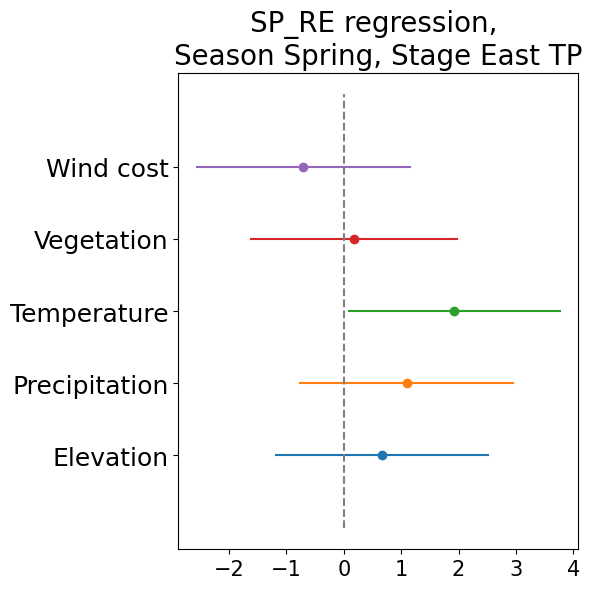

Compiling...
Compilation time =  0:00:00.438610
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:01.718734
Transforming variables...
Transformation time =  0:00:00.012262


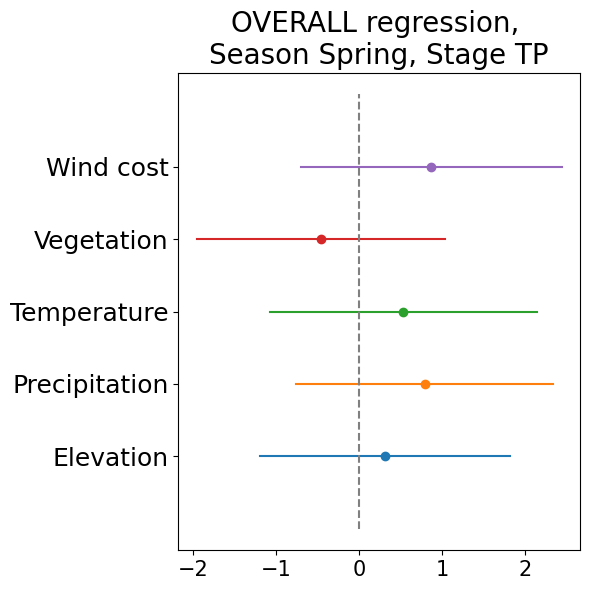

Compiling...
Compilation time =  0:00:01.972432
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:04.251173
Transforming variables...
Transformation time =  0:00:00.045961


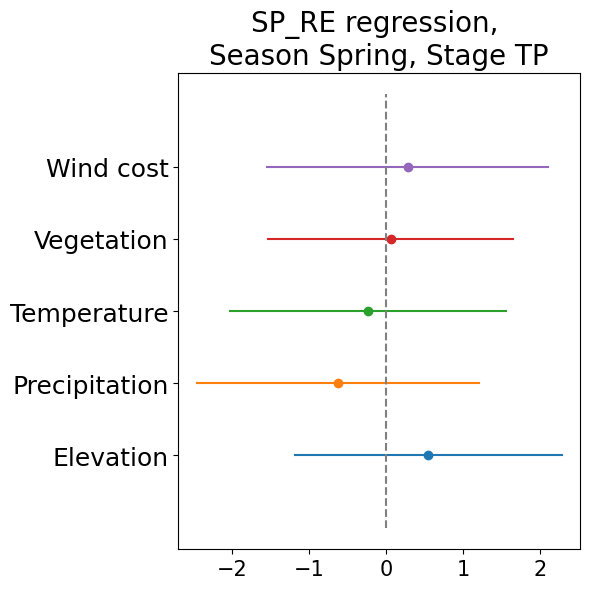

Compiling...
Compilation time =  0:00:00.470503
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:01.924793
Transforming variables...
Transformation time =  0:00:00.011565


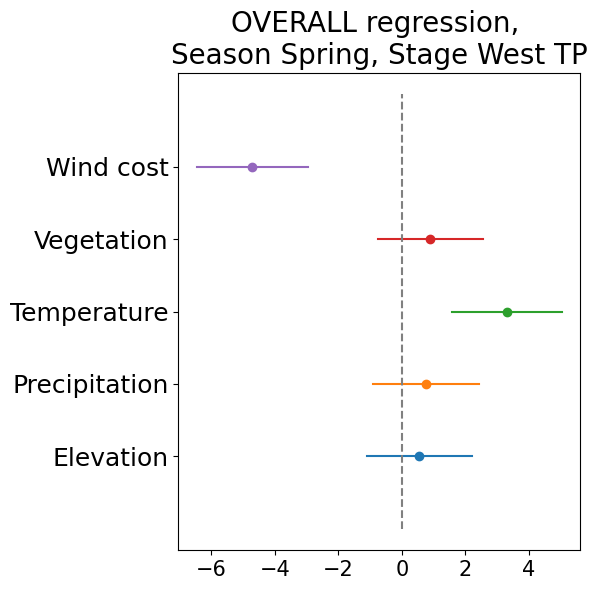

Compiling...
Compilation time =  0:00:00.912132
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:03.486912
Transforming variables...
Transformation time =  0:00:00.031370


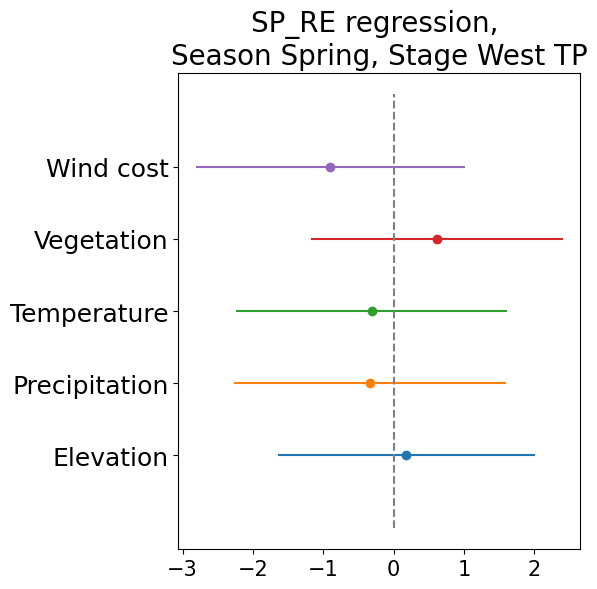

Compiling...
Compilation time =  0:00:00.437194
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:01.801299
Transforming variables...
Transformation time =  0:00:00.023439


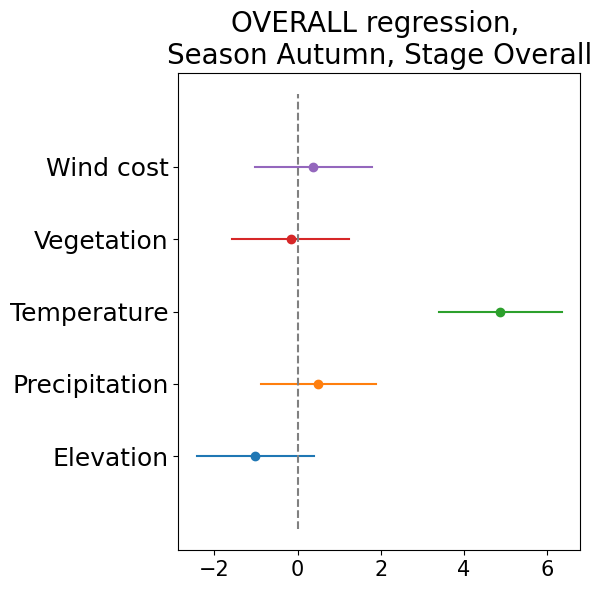

Compiling...
Compilation time =  0:00:00.850724
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:03.470714
Transforming variables...
Transformation time =  0:00:00.101623


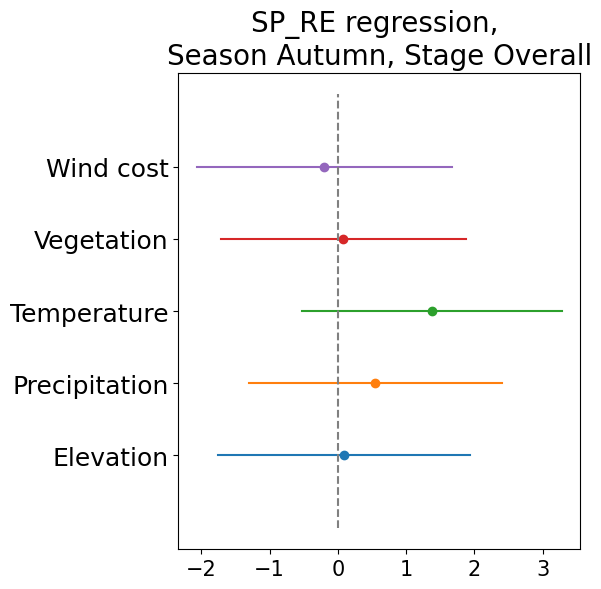

Compiling...
Compilation time =  0:00:00.447906
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:01.830211
Transforming variables...
Transformation time =  0:00:00.022894


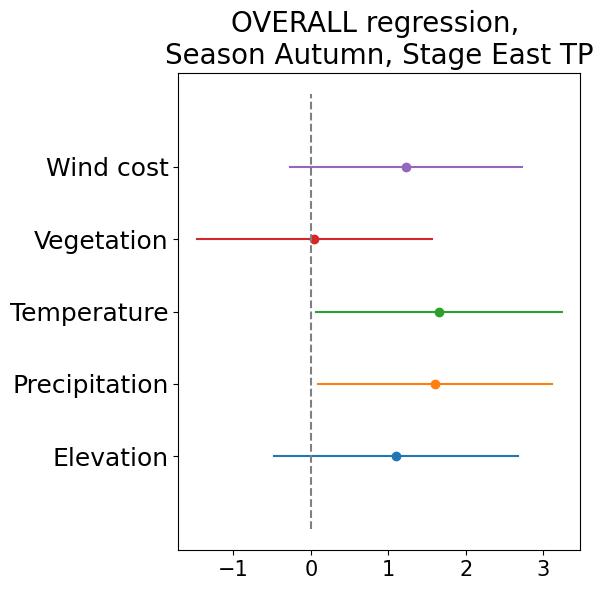

Compiling...
Compilation time =  0:00:00.881786
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:03.382436
Transforming variables...
Transformation time =  0:00:00.039395


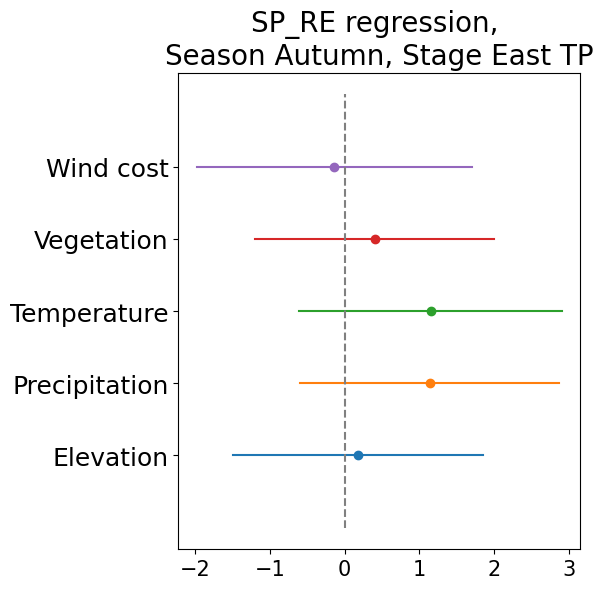

Compiling...
Compilation time =  0:00:00.431915
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:01.696380
Transforming variables...
Transformation time =  0:00:00.014561


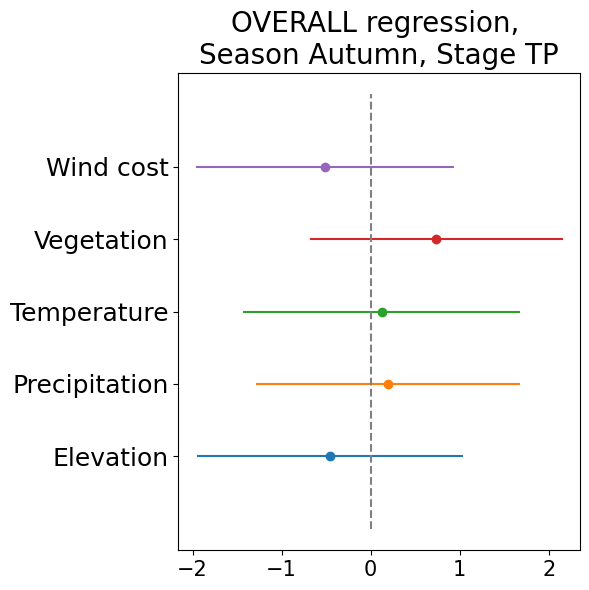

Compiling...
Compilation time =  0:00:00.844449
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:04.071663
Transforming variables...
Transformation time =  0:00:00.031706


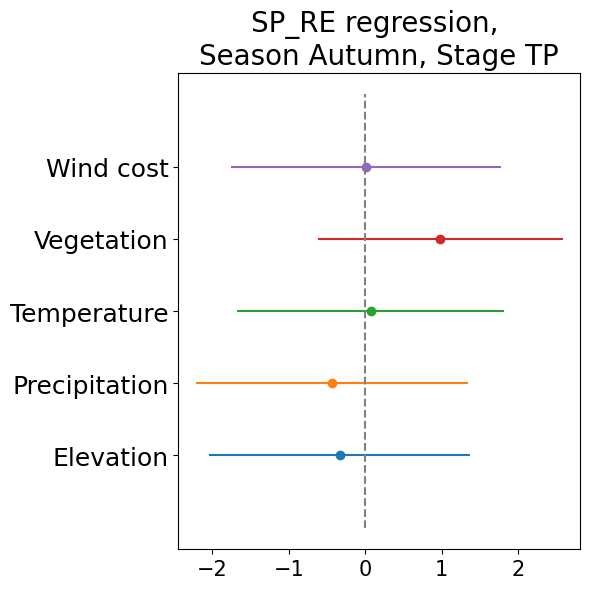

Compiling...
Compilation time =  0:00:00.487049
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:01.976497
Transforming variables...
Transformation time =  0:00:00.011453


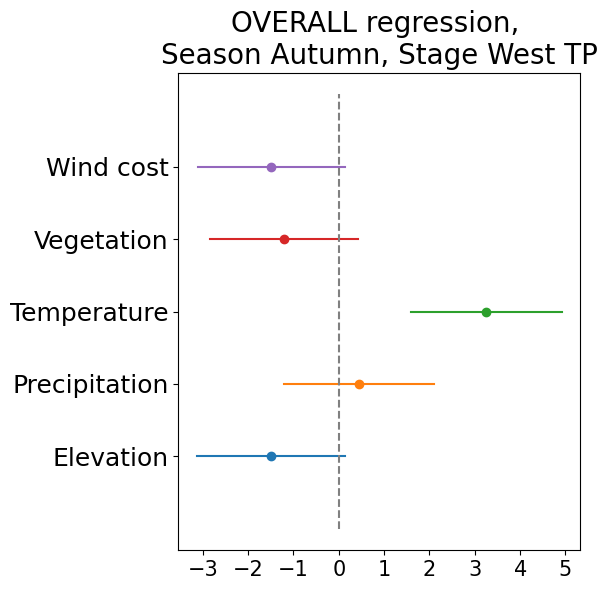

Compiling...
Compilation time =  0:00:00.957936
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:03.129320
Transforming variables...
Transformation time =  0:00:00.033003


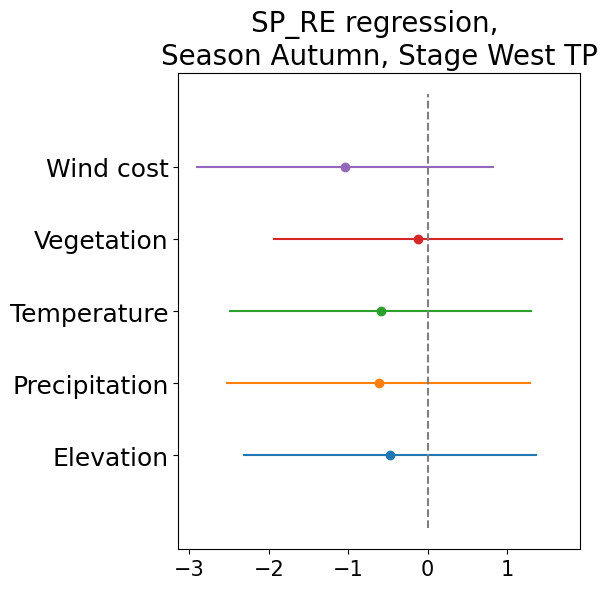

In [35]:
for dat_col,sa in zip(['dir_spr', 'dir_aut'],['Spring','Autumn']):

    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import SimpleImputer, IterativeImputer
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.preprocessing import StandardScaler

    x_names = ['Wind','prec','tprt','ele','evi']
    data_one_season = data[data.sa==sa]
    
    data_east = data_one_season[data_one_season.lon<73]
    data_across = data_one_season[(data_one_season.lon>=73) & (data_one_season.lon<105)]
    data_west = data_one_season[data_one_season.lon>=105]
    data_overall = data_one_season.copy()
    
    #### Now, run seperate model for overall, east, across, and west TP
    for the_data, the_label in zip([data_overall, data_east, data_across, data_west],
                                   ['Overall', 'East TP', 'TP', 'West TP']):
        
        ## name change
        r_the_label = the_label.replace(' ','_')
        
        #### random forest imputation
        imputer = IterativeImputer(random_state=42, estimator=RandomForestRegressor(random_state=42))
        the_data = the_data[x_names + [dat_col,'sp']]
        the_data = the_data.dropna(subset=dat_col)
        
        # ### add quadradic term
        # for i in x_names:
        #     data_one_season[f'{i}_2'] = data_one_season[i]**2
        # x_names.extend([f'{i}_2' for i in x_names])
            
        ### indexing name
        sp_index = pd.factorize(the_data['sp'])[0]
        sp_name = the_data['sp']
        del the_data['sp']

        ### Making X and y for regression
        the_data[the_data.columns] = imputer.fit_transform(the_data)
        y = the_data[dat_col]
        x = the_data[x_names]
        x_stded = x.copy()
        x_stded[x_stded.columns] = StandardScaler().fit_transform(x_stded)

        #### making reg1
        TUNES = 3000
        for i in range(5):
            idata = BS_regression_sp_overall(x_stded, y, TUNES)
            pass_ = check_convergence(idata, x_names)
            if not pass_:
                if i==4:
                    raise
                else:
                    TUNES*=2
            else:
                break
    
        plot_df = forest_plot(idata, x_names)
        plot_df.to_csv(f'./df/OVERALL_regression_{sa}_Stage_{r_the_label}.csv',index=False)
        plt.title(f'OVERALL regression, \nSeason {sa}, Stage {the_label}', fontsize=20)
        plt.tight_layout()
        plt.savefig(f'./Charts/OVERALL_regression_{sa}_Stage_{r_the_label}.pdf', dpi=500)
        plt.show()
        
        #### making reg2
        TUNES = 3000
        for i in range(5):
            idata = BS_regression_sp_as_random_effect(x_stded, y, sp_index, TUNES)
            pass_ = check_convergence(idata, x_names)
            if not pass_:
                if i==4:
                    raise
                else:
                    TUNES*=2
            else:
                break
            
        
        plot_df = forest_plot(idata, x_names)
        plot_df.to_csv(f'./df/SP_RE_regression_{sa}_Stage_{r_the_label}.csv',index=False)
        plt.title(f'SP_RE regression, \nSeason {sa}, Stage {the_label}', fontsize=20)
        plt.tight_layout()
        plt.savefig(f'./Charts/SP_RE_regression_{sa}_Stage_{r_the_label}.pdf', dpi=500)
        plt.show()
        
    


## Replot

In [115]:
def new_forest_plot(plot_df, ax, region_count, season_count, font_size=13):
    '''
    Plot the regression coefficients
    '''

    var_replace_list = {
        'Wind': 'Wind cost', 
        'prec': 'Precipitation', 
        'tprt': 'Temperature', 
        'ele': 'Elevation', 
        'evi': 'Vegetation'
    }
    for k in var_replace_list.keys():
        plot_df['var'] = plot_df['var'].replace(k, var_replace_list[k])
    
    plot_df = plot_df.sort_values(by='var').reset_index(drop=True)

    for index,i in plot_df.iterrows():
        ax[region_count, season_count].plot(
            [i.mean_eff - 1.96*i.std_eff, i.mean_eff  + 1.96*i.std_eff],
            [index, index]
        )
        ax[region_count, season_count].scatter(
            [i.mean_eff],[index]
        )

    ax[region_count, season_count].axvline(0, linestyle='dashed', color='grey')

    if season_count==0:
        ax[region_count, season_count].set_yticks(list(range(len(plot_df['var']))), list(plot_df['var']), fontsize=font_size, fontname='Arial')
        
    if region_count==0:
        season = 'Spring' if season_count==0 else 'Autumn'
        ax[region_count, season_count].set_title(season, fontsize=font_size, fontname='Arial')

    if season_count==1:
        ax[region_count, season_count].set_yticks([])

        twin_ = plt.twinx(ax[region_count, season_count])
        twin_.set_yticks([])
        twin_.set_ylabel(['Overall', 'East TP', 'TP', 'West TP'][region_count], rotation=-90, labelpad=15, fontsize=font_size, fontname='Arial')

        
    ax[region_count, season_count].set_xlim(-6,6)

    


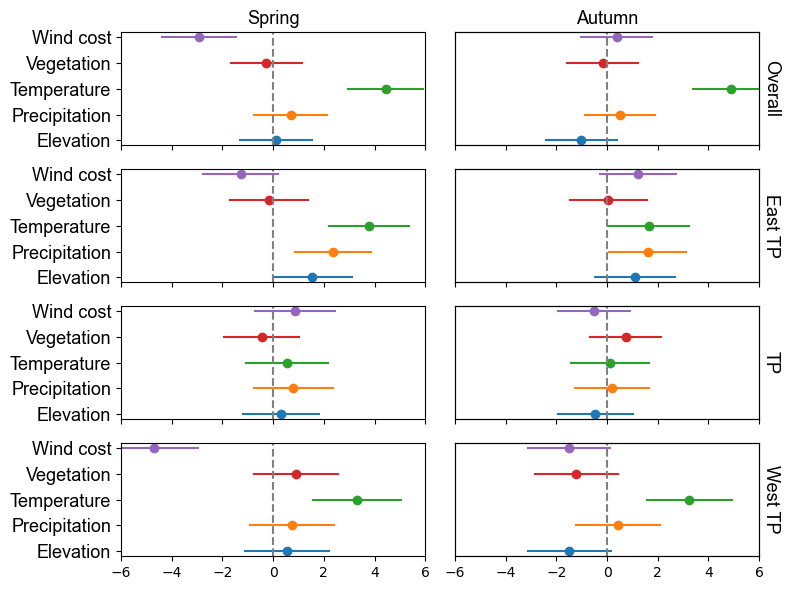

In [123]:
method='OVERALL'
fig, ax = plt.subplots(4,2,figsize=(8,6), sharex=True)

for season_count,season in enumerate(['Spring','Autumn']):

    x_names = ['Wind','prec','tprt','ele','evi']
    
    #### Now, run seperate model for overall, east, across, and west TP
    for region_count, region in enumerate(['Overall', 'East TP', 'TP', 'West TP']):
        region_str = region.replace(' ','_')
        file_name = f'./df/{method}_regression_{season}_Stage_{region_str}.csv'
        data = pd.read_csv(file_name)

        new_forest_plot(data, ax, region_count, season_count)


# fig.xlabel('Test')
plt.tight_layout()
plt.savefig('./Charts/OVERALL_replot_Mar26_2024.pdf', bbox_inches='tight')


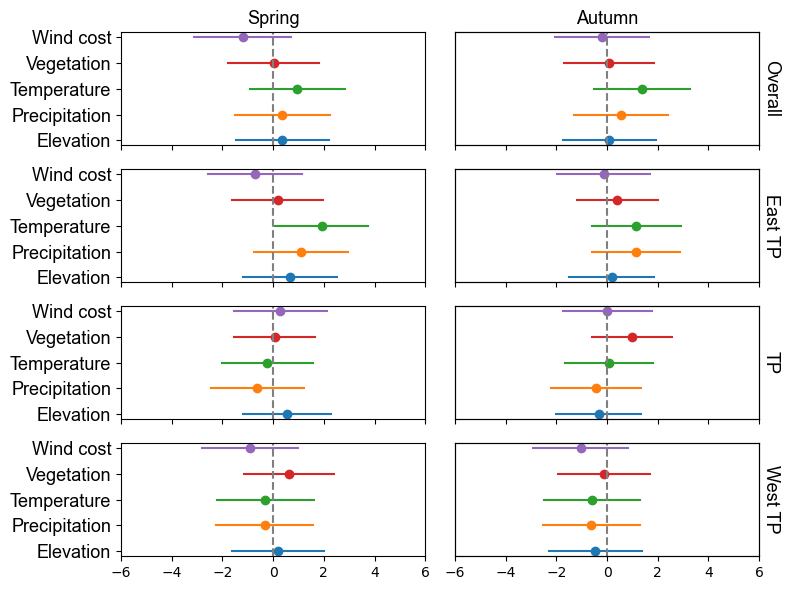

In [124]:
method='SP_RE'
fig, ax = plt.subplots(4,2,figsize=(8,6), sharex=True)

for season_count,season in enumerate(['Spring','Autumn']):

    x_names = ['Wind','prec','tprt','ele','evi']
    
    #### Now, run seperate model for overall, east, across, and west TP
    for region_count, region in enumerate(['Overall', 'East TP', 'TP', 'West TP']):
        region_str = region.replace(' ','_')
        file_name = f'./df/{method}_regression_{season}_Stage_{region_str}.csv'
        data = pd.read_csv(file_name)

        new_forest_plot(data, ax, region_count, season_count)


# fig.xlabel('Test')
plt.tight_layout()
plt.savefig('./Charts/SP_RE_replot_Mar26_2024.pdf', bbox_inches='tight')
